In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def visualize(data, y, x, hues, chart):
    plt.figure(figsize=(12,8))
    match chart:
        case 'line':
            chart_type = sns.lineplot
        case 'bar':
            chart_type = sns.barplot
        case 'box':
            chart_type = sns.boxplot
    try:
        if len(hues) > 1:
            data['hues'] = data[hues].astype(str).agg('-'.join, axis=1)
        else:
            data['hues'] = data[hues[0]]

        chart_type(data=data,x = x, y = y, hue='hues', palette='viridis')

        plt.legend(title=f'{y} for {x}, sorted by {[h + ", " for h in hues]}')
        plt.show()
    except (KeyError, ValueError):
        print(f"You've passed an incorrect column name.\n The correct ones are: \n{data.columns}")
    


### Configure the results you want to visualize under.



In [71]:
strings = ["results_papergraph_error_mitigation_{False, True}.csv",
"results_papergraph_qaoa_variant_{'vanilla', 'multiangle'}_warm_start_{False, True}_depth_{1, 4}_error_mitigation_{False, True}.csv",
"results_papergraph_qaoa_variant_{'vanilla', 'multiangle'}_warm_start_{False, True}_error_mitigation_{False, True}.csv",
"results_papergraph_warm_start_{False, True}_depth_{1, 4}_error_mitigation_{False, True}.csv",
"results_papergraph_warm_start_{False, True}_error_mitigation_{False, True}.csv"]

for file in strings:
    try:
        df = pd.read_csv(file, index_col=0)
        print(f"File: {file}")
        print(df['graph_name'].value_counts())
        print("\n")
    except FileNotFoundError:
        print(f"File not found: {file}")

if len(strings) >1:
    results = pd.concat([pd.read_csv(path, index_col=0) for path in strings])

else:
    results = pd.read_csv(strings[0],index_col=0)
results['ratio'] = results['quantum_obj_value']/results['classic_value']
#rint(results.head())
print(results.columns)

File: results_papergraph_error_mitigation_{False, True}.csv
graph_name
>>graph6<<DkO        22
>>graph6<<Dm{        21
>>graph6<<FkPsg      20
>>graph6<<Fm~]w      20
>>graph6<<HkPsgZ@    20
>>graph6<<Hm~]x^^    19
Name: count, dtype: int64


File: results_papergraph_qaoa_variant_{'vanilla', 'multiangle'}_warm_start_{False, True}_depth_{1, 4}_error_mitigation_{False, True}.csv
graph_name
>>graph6<<DkO        537
>>graph6<<Dm{        537
>>graph6<<FkPsg      536
>>graph6<<Fm~]w      536
>>graph6<<HkPsgZ@    533
>>graph6<<Hm~]x^^    531
Name: count, dtype: int64


File: results_papergraph_qaoa_variant_{'vanilla', 'multiangle'}_warm_start_{False, True}_error_mitigation_{False, True}.csv
graph_name
>>graph6<<DkO        64
>>graph6<<Dm{        63
>>graph6<<FkPsg      63
>>graph6<<Fm~]w      62
>>graph6<<HkPsgZ@    60
>>graph6<<Hm~]x^^    58
Name: count, dtype: int64


File: results_papergraph_warm_start_{False, True}_depth_{1, 4}_error_mitigation_{False, True}.csv
graph_name
>>graph6<<DkO  

In [68]:
threshold = 1  # Replace <value> with the desired threshold
filtered_rows = results[results['ratio'] < threshold]
print(filtered_rows)

     param_initialization optimizer qaoa_variant  warm_start  errors  depth  \
2                gaussian    COBYLA   multiangle       False    True     12   
14               gaussian    COBYLA   multiangle       False    True     12   
16               gaussian    COBYLA   multiangle       False    True     12   
28               gaussian    COBYLA   multiangle       False    True     12   
30               gaussian    COBYLA   multiangle       False    True     12   
...                   ...       ...          ...         ...     ...    ...   
1194             gaussian    COBYLA      vanilla        True    True     12   
1195             gaussian    COBYLA      vanilla        True    True     12   
1196             gaussian    COBYLA      vanilla        True    True     12   
1198             gaussian    COBYLA      vanilla        True    True     12   
1199             gaussian    COBYLA      vanilla        True    True     12   

      lagrangian_multiplier  amount_shots       max

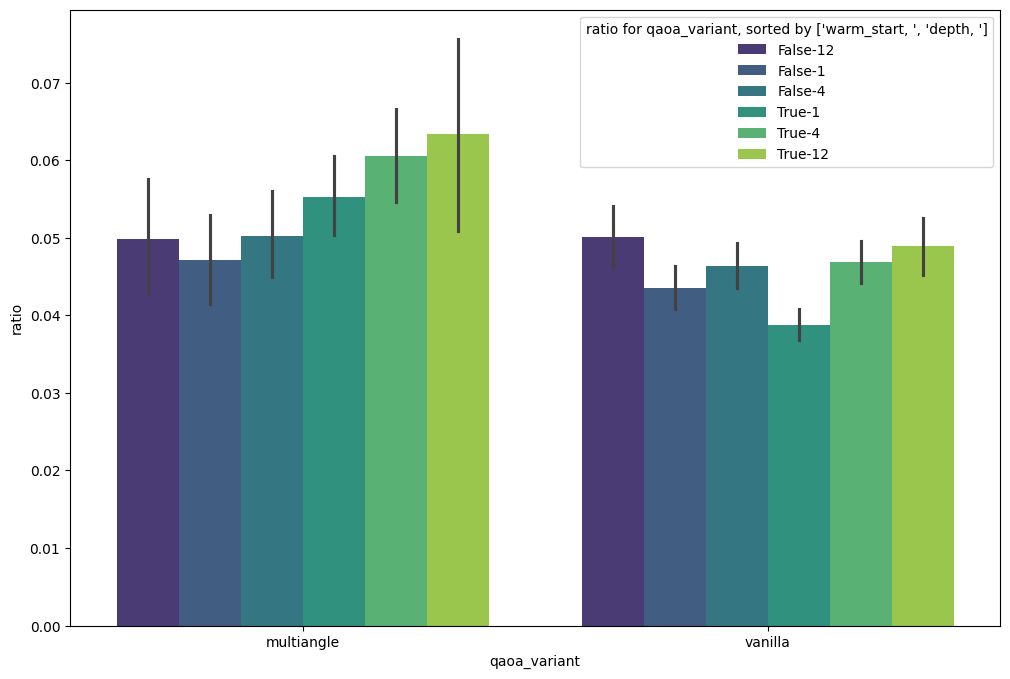

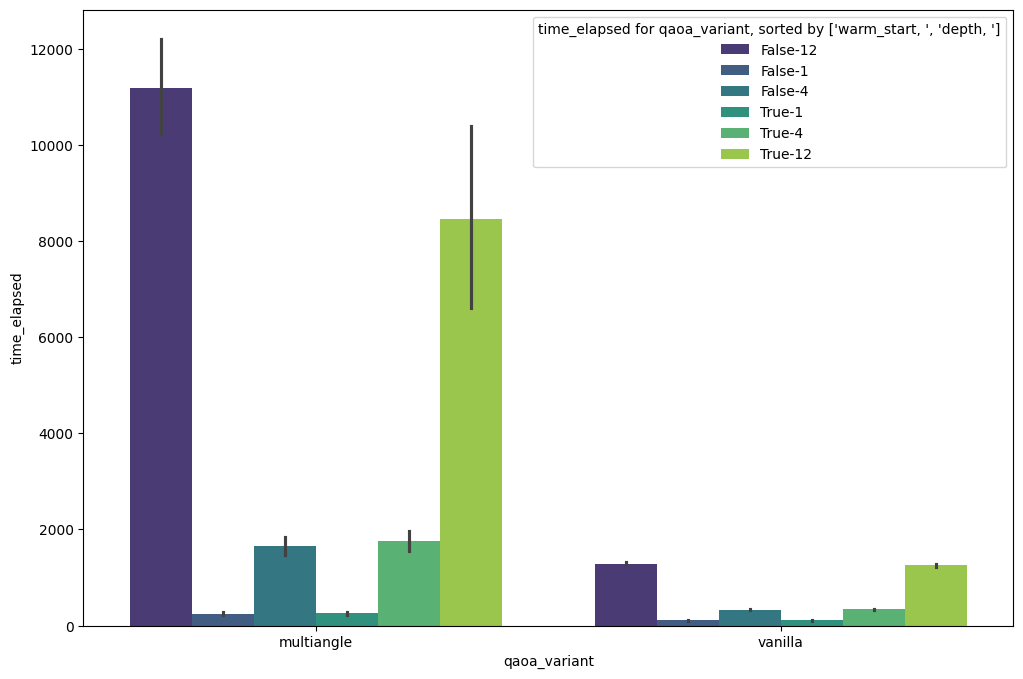

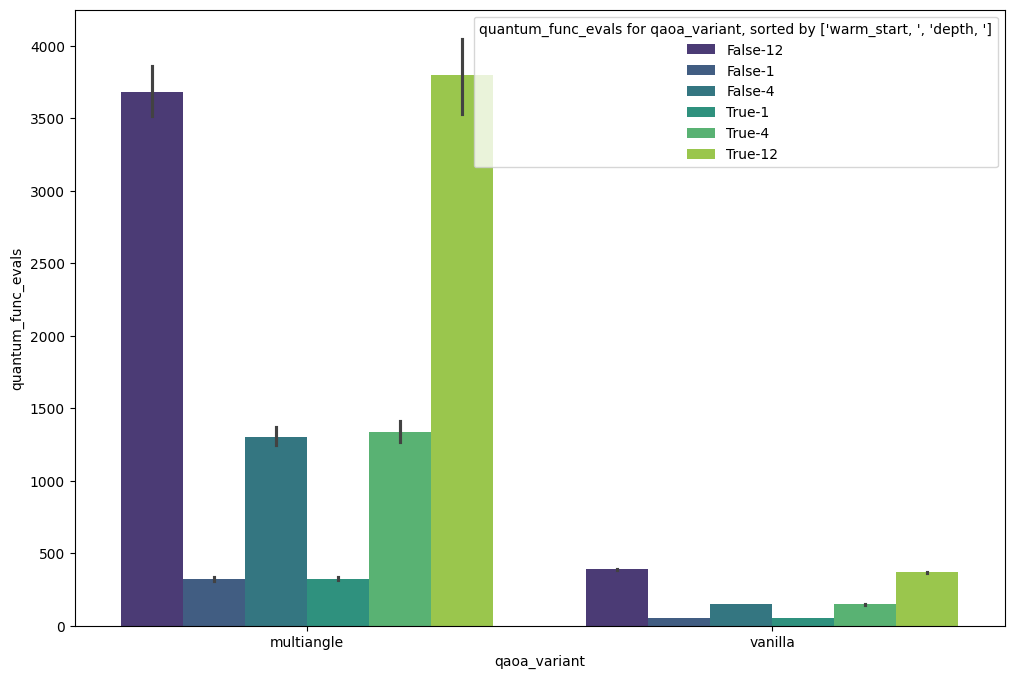

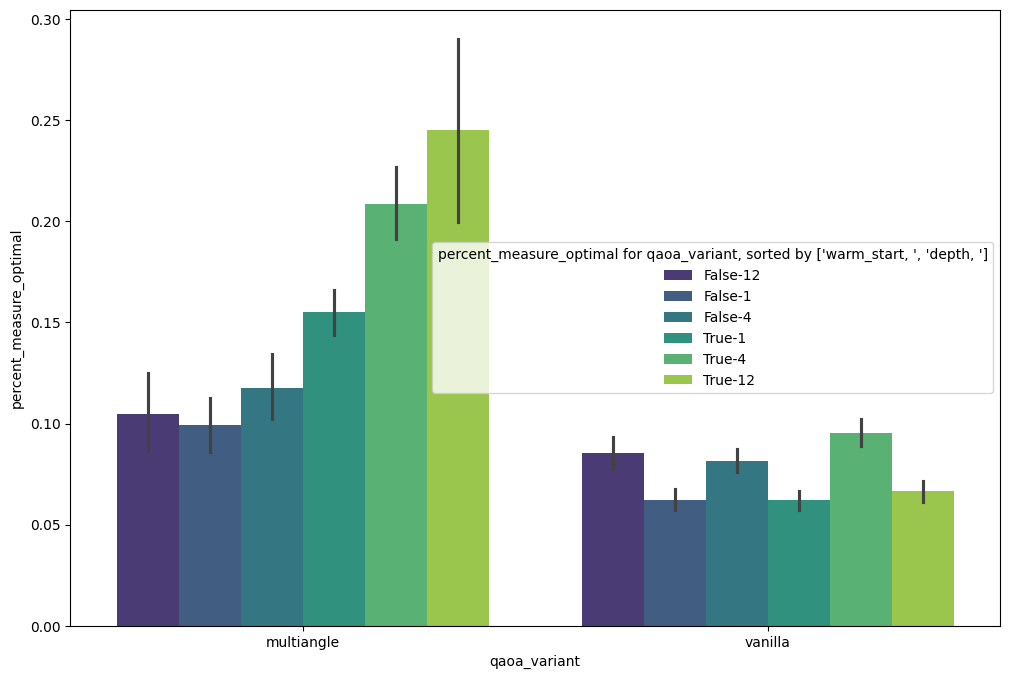

<Figure size 640x480 with 0 Axes>

In [70]:
y_values = ['ratio', 'time_elapsed', 'quantum_func_evals', 'percent_measure_optimal']
x = 'qaoa_variant'
hues = ['warm_start', 'depth']

for y in y_values:
    visualize(results, y, x, hues, 'bar')
plt.tight_layout()
